1. Let's consider projection of our dataset to one-dimensional space of ith feature.

    a) m<sub>H</sub>(N) = 2N
    
    We have n-1 ways to mark not empty prefix of points as negative and the rest as positive and the same for inverted labels. Plus cases of entire negative or positive dataset.
    
    Breakpoint k = 3 since 2 * 3 != 2<sup>3</sup>.
    
    d<sub>VC</sub>(h) = k - 1 = 2 
    
    b) m<sub>H</sub>(N) = 2N + 2(N - 1)(N - 2) / 2 = N<sup>2</sup> - N + 2
    
    Now we add to the previous result cases with one label surrounded by not empty continuous segments of other label. It's N - 1 choose 2 for each label in the center.
    
    Breakpoint k = 4 since 16 - 4 + 2 != 2<sup>4</sup>.
    
    d<sub>VC</sub>(h) = k - 1 = 3


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import norm
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from random import shuffle


def read_dataset(dataset, to_labels=None):
    data = pd.read_csv(dataset)
    Y = data['label'].to_numpy()
    X = data.drop('label', axis=1).to_numpy()
    if to_labels:
        Y = np.array([to_labels[y] for y in Y])
    return X, Y


X, Y = read_dataset('blobs2.csv', {0: -1, 1: 1})
train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.20)


def error(hyp, Y):
    return np.sum(hyp != Y) / Y.shape[0]


def pocket_perceptron(train, labels_train, test, labels_test, iterations=1000, degree=1):
    features = PolynomialFeatures(degree)
    train = features.fit_transform(train)
    test = features.fit_transform(test)
    w_opt = w = np.random.uniform(-1, 1, train.shape[1])
    hyp_train = np.sign(np.dot(train, w))
    hyp_test = np.sign(np.dot(test, w))
    error_opt = error(hyp_test, labels_test)
    print(f'init error {error_opt}')
    for i in tqdm_notebook(range(iterations)):
        diff = hyp_train != labels_train
        idx = np.random.choice(range(np.sum(diff)))
        w += labels_train[diff][idx] * train[diff][idx]
        hyp_test = np.sign(np.dot(test, w))
        hyp_train = np.sign(np.dot(train, w))
        err = error(hyp_test, labels_test)
        if err < error_opt:
            error_opt = err
            print(f'error on test {error_opt}')
            w_opt = w 
    return w_opt


def plot(X, Y, contour, delta=0.01):
    X_pos = X[Y == 1]
    X_neg = X[Y == -1]
    plt.scatter(X_pos[:, 0], X_pos[:, 1])
    plt.scatter(X_neg[:, 0], X_neg[:, 1])
    grid_x = np.arange(np.min(X[:, 0]), np.max(X[:, 0]), delta)
    grid_y = np.arange(np.min(X[:, 1]), np.max(X[:, 1]), delta)
    X, Y = np.meshgrid(grid_x, grid_y)
    plt.contour(X, Y, contour(X, Y), [0])

init error 0.495


error on test 0.47
error on test 0.11
error on test 0.04
error on test 0.03
error on test 0.025
error on test 0.02
error on test 0.015
error on test 0.01



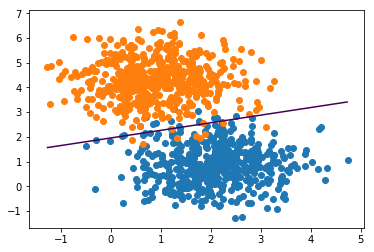

In [46]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2])

init error 0.855


error on test 0.505
error on test 0.275
error on test 0.09
error on test 0.04
error on test 0.03
error on test 0.02
error on test 0.015
error on test 0.01



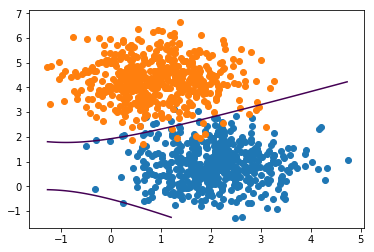

In [58]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=2)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5])

init error 0.445


error on test 0.045
error on test 0.035
error on test 0.03
error on test 0.025
error on test 0.02
error on test 0.015
error on test 0.01
error on test 0.005



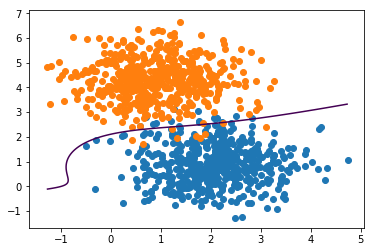

In [51]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=3)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                        x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9])

init error 0.495


error on test 0.38
error on test 0.365
error on test 0.245
error on test 0.215
error on test 0.145
error on test 0.14
error on test 0.105
error on test 0.095
error on test 0.08
error on test 0.05
error on test 0.04
error on test 0.035
error on test 0.03
error on test 0.02
error on test 0.015
error on test 0.01
error on test 0.005



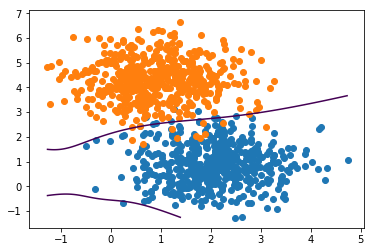

In [56]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=4)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] + 
                        x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9] + 
                        x ** 4 * w[10] + x ** 3 * y * w[11] + (x * y) ** 2 * w[12] + x * y ** 3 * w[13] + 
                        y ** 4 * w[14])

In [120]:
def scale(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)
    
    
def polynomial_features(X, degree=1):
    features = PolynomialFeatures(degree)
    return features.fit_transform(X)


def batches(X, batch_size):
    indicies = np.random.permutation(X.shape[0])
    for i in range(0, indicies.shape[0], batch_size):
        yield indicies[i : i + batch_size]
        
        
def accuracy(X, Y, w):
    return np.sum(np.sign(np.dot(X, w)) == Y) / Y.shape[0]
    
    
def logistic_regression(train, labels_train, test, labels_test, batch_size=50, epochs=50, learning_rate=1):
    w = np.random.uniform(-1, 1, train.shape[1])
    accuracies = []
    for epoch in tqdm_notebook(range(epochs)):
        for batch in batches(train, batch_size):
            gradient = np.zeros(w.shape)
            for i in batch:
                y = labels_train[i]
                x = train[i]
                gradient += y * x / (1 + np.exp(y * np.dot(w, x)))
            w += learning_rate * gradient / len(batch)
        accuracies.append(accuracy(test, labels_test, w))
    return accuracies

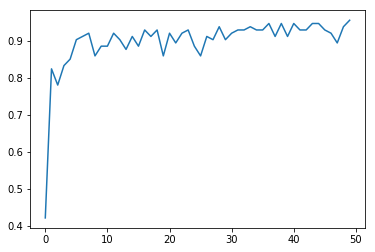

In [121]:
X, Y = read_dataset('cancer.csv', {'M': 1, 'B': -1})
X = scale(X)
X = polynomial_features(X)

train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.2)
accuracies = logistic_regression(train, labels_train, test, labels_test)
plt.plot(range(len(accuracies)), accuracies)

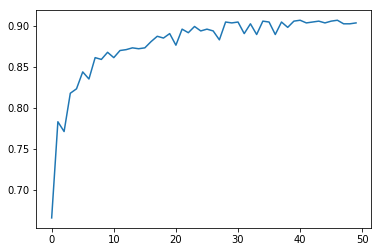

In [124]:
X, Y = read_dataset('spam.csv', {1: 1, 0: -1})
X = scale(X)
X = polynomial_features(X)

train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.2)
accuracies = logistic_regression(train, labels_train, test, labels_test)
plt.plot(range(len(accuracies)), accuracies)

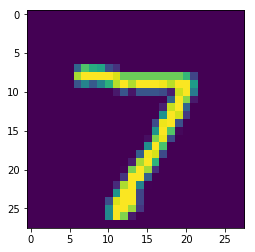

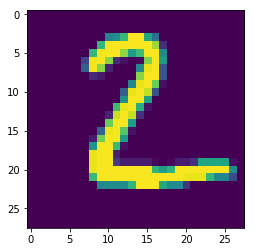

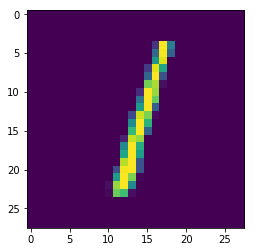

In [133]:
#%matplotlib inline
X, Y = read_dataset('mnist.csv')
X = X.reshape(-1, 28, 28)
for num in X[:3]:
    plt.cla()
    plt.imshow(num)
    plt.show()